In [16]:
import glob
import numpy as np
import hyss_util as hu
from datetime import datetime
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from plotting import set_defaults
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# -- set the types

kind = "veg"
comp = "new"
runpca = False
runfan = False
runica = False
getndvi = True

In [4]:
# -- get wavelengths
waves = hu.read_header("../../../image_files/veg_00000.hdr")["waves"]

# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])

reading and parsing ../../../image_files/veg_00000.hdr...


In [5]:
# -- load the comparison set
print("getting {0} spectra...".format(comp))
blds = np.array([np.load(i) for i in
                 sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs_avg*.npy"\
                                      .format(comp)))])
blds = blds[good]

getting new spectra...


In [6]:
# -- normalize spectra
ms, bs = [], []
for ii in range(blds.shape[0]):
    # m, b = np.polyfit(blds[ii,:100],blds[0,:100],1)
    # m, b = np.polyfit(blds[ii],blds[0],1)
    m = blds[0].mean()/blds[ii].mean()
    b = 0.0
    ms.append(m)
    bs.append(b)

ms   = np.array(ms)
bs   = np.array(bs)
norm = blds*ms[:,np.newaxis] + bs[:,np.newaxis]
rat  = norm/norm[0]

In [7]:
# -- get vegetation spectra
print("getting {0} spectra...".format(kind))
if kind=="veg":
    vegs = np.load("../../../gdobler_output/output/veg_patch_specs.npy")
else:
    vegs = np.array([np.load(i) for i in
                     sorted(glob.glob("../../../gdobler_output/output/" + 
                                      "{0}_specs/{0}_specs_avg*.npy" \
                                      .format(kind)))])
    vegs = vegs[good]

getting veg spectra...


In [8]:
# -- normalize spectra
ss, os = [], []
for ii in range(vegs.shape[0]):
    # s, o = np.polyfit(vegs[ii,:100],vegs[0,:100],1)
    # s, o = np.polyfit(vegs[ii],vegs[0],1)
    s = vegs[0].mean()/vegs[ii].mean()
    o = 0.0
    ss.append(s)
    os.append(o)

ss    = np.array(ss)
os    = np.array(os)
vnorm = vegs*ss[:,np.newaxis] + os[:,np.newaxis]
vrat  = vnorm/vnorm[0]

In [9]:
# -- take the ratio of ratios
brat = vrat/rat

In [10]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [11]:
# -- PCA
if runpca:
    print("running PCA...")
    pca = PCA(n_components=6)
    pca.fit(vrat/rat)
    pamps = pca.transform(vrat/rat)

# -- Factor Analysis
if runfan:
    print("running Factor Analysis...")
    fan = FactorAnalysis(n_components=6)
    fan.fit(vrat/rat)
    famps = fan.transform(vrat/rat)

# -- ICA
if runica:
    print("running ICA...")
    ica = FastICA(n_components=6)
    ica.fit(vrat/rat)
    iamps = ica.transform(vrat/rat)

In [12]:
# -- get NDVI
if getndvi:
    print("calculating NDVI...")
    print("  getting sky spectra...")
    flist   = sorted(glob.glob("../../../gdobler_output/output/sky_specs/*.npy"))
    skys    = np.array([np.load(i) for i in flist])[good]
    print("  getting reflectance...")
    ref     = (vegs - vegs.min(1,keepdims=True))/ \
        (skys-skys.min(1,keepdims=True))
    ind_ir  = np.argmin(np.abs(waves-860.))
    ind_vis = np.argmin(np.abs(waves-670.))
    print("  generating NDVI...")
    ndvi    = (ref[:,ind_ir]-ref[:,ind_vis]) / \
        (ref[:,ind_ir]+ref[:,ind_vis])

calculating NDVI...
  getting sky spectra...
  getting reflectance...
  generating NDVI...


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## Linear Least Squares - no errors

In [14]:
brightness = brat[:,500]/brat[:,-1]
templates  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
ind  = np.arange(len(brightness))
sol  = np.linalg.lstsq(templates[ind],brightness[ind], rcond=None)
pred = np.dot(templates[ind],sol[0])

In [15]:
# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol[1] / (len(brightness) * brightness.var())
print("sol = ", sol)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 1.57925507e+00, -8.70778400e-03,  6.28846794e-03, -1.40824696e-03,
        7.97202669e-01]), array([30.34580005]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.27087302]


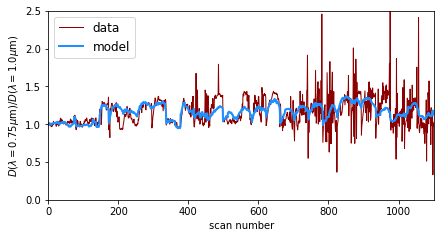

In [17]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(brightness,color="darkred",lw=1)
linp, = ax.plot(pred,color="dodgerblue",lw=2)
ax.set_ylim(0,2.5)
ax.set_xlim(0,pred.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

## Maximum Likelihood Estimation

$brightness = m_{O_3} * O_3 + m_{PM2.5} * PM2.5 + m_{temp} * temp + m_{humid} * humid + b$

uncertainty in brightness obtained using difference of neighbors

assuming the quoted uncertainty is underestimated by a constant amount $f$

In [32]:
# -- obtaining uncertainty for brightness
brightness = brat[:,500]/brat[:,-1]
diff = brightness[1:] - brightness[:-1]
berr = diff.std()/np.sqrt(2.0)
print("error in brightness = ", berr)

error in brightness =  0.15106653600091366


In [33]:
# -- obtaining uncertainty for air quality
templates  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air qaulity = ", air_err)

errors in air qaulity =  [2.50960907e-03 7.69473073e-01 1.30383320e+00 2.97720678e+00
 0.00000000e+00]


In [34]:
brightness_err = np.full(brightness.shape, berr)
o3err = np.full(brightness.shape, air_err[0])
pm25err = np.full(brightness.shape, air_err[1])
temperr = np.full(brightness.shape, air_err[2])
humiderr = np.full(brightness.shape, air_err[3])
alphaerr = np.full(brightness.shape, air_err[4])
terr = np.vstack([o3err,pm25err,temperr,humiderr,alphaerr]).T

In [57]:
# -- define log-likelihood function

def log_likelihood(theta, o3, pm25, temps, humid, y, yerr):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, log_f = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


In [90]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(sol[0], 1.0)
soln = minimize(nll, initial, args=(templates[:,0], templates[:,1], templates[:,2], 
                                    templates[:,3], brightness, brightness_err))
beta_o3_ml, beta_pm25_ml, beta_temps_ml, beta_humid_ml, alpha_ml, log_f_ml = soln.x

In [92]:
print("Maximum likelihood estimates:")
print("beta_o3 = {0:.5f}".format(beta_o3_ml))
print("beta_pm25 = {0:.5f}".format(beta_pm25_ml))
print("beta_temps = {0:.5f}".format(beta_temps_ml))
print("beta_humid = {0:.5f}".format(beta_humid_ml))
print("alpha = {0:.5f}".format(alpha_ml))
print("f = {0:.5f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
beta_o3 = 1.55731
beta_pm25 = -0.00923
beta_temps = 0.00667
beta_humid = -0.00131
alpha = 0.76943
f = 0.06347


## MCMC

In [93]:
# -- define log-prior function

def log_prior(theta):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, log_f = theta
    if (-5.0 < beta_o3 < 5.0 and
        -5.0 < beta_pm25 < 0.5 and
        -5.0 < beta_temps < 0.5 and
        -5.0 < beta_humid < 0.5 and
        -5.0 < alpha < 5.0 and
        -5.0 < log_f < 5.0):
        return 0.0
    return -np.inf

In [99]:
# -- define the full log-probability function

def log_probability(theta, o3, pm25, temps, humid, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, o3, pm25, temps, humid, y, yerr)

In [100]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee

nwalkers, ndim = 50, 6
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [102]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(templates[:,0], templates[:,1], templates[:,2], 
                                    templates[:,3], brightness, brightness_err))
sampler.run_mcmc(pos, 5000, progress=True)

State([[ 2.71273112e+00 -9.44746678e-03  5.86146697e-03 -6.03885797e-04
   7.45106016e-01 -2.67330481e+00]
 [ 1.06056981e+00 -1.15559095e-02  8.35904432e-03 -9.90377224e-04
   6.74328271e-01 -2.82066122e+00]
 [ 1.79205671e+00 -1.17845081e-02  7.19811176e-03 -1.37948249e-03
   7.51635136e-01 -2.84815421e+00]
 [ 1.46771267e+00 -7.68912291e-03  6.38202855e-03 -1.40468344e-03
   7.90103325e-01 -2.84283237e+00]
 [ 2.78887563e-01 -8.97782693e-03  6.74216501e-03 -1.82519380e-03
   8.35512923e-01 -2.56620394e+00]
 [ 1.41574503e+00 -1.01566211e-02  7.24287430e-03 -1.60911345e-03
   7.57850835e-01 -2.66994067e+00]
 [ 1.35344280e+00 -8.51337864e-03  6.49576007e-03 -1.43104183e-03
   7.92281928e-01 -2.92620901e+00]
 [ 3.45180942e+00 -7.98643823e-03  3.97180171e-03 -1.08245214e-03
   8.70260015e-01 -2.77463802e+00]
 [ 2.35359506e-01 -4.21805047e-03  6.85223410e-03 -1.78159517e-03
   8.05709222e-01 -2.69294803e+00]
 [ 2.00364045e+00 -1.17745220e-02  6.20806213e-03 -1.21550626e-03
   7.92689199e-01 -

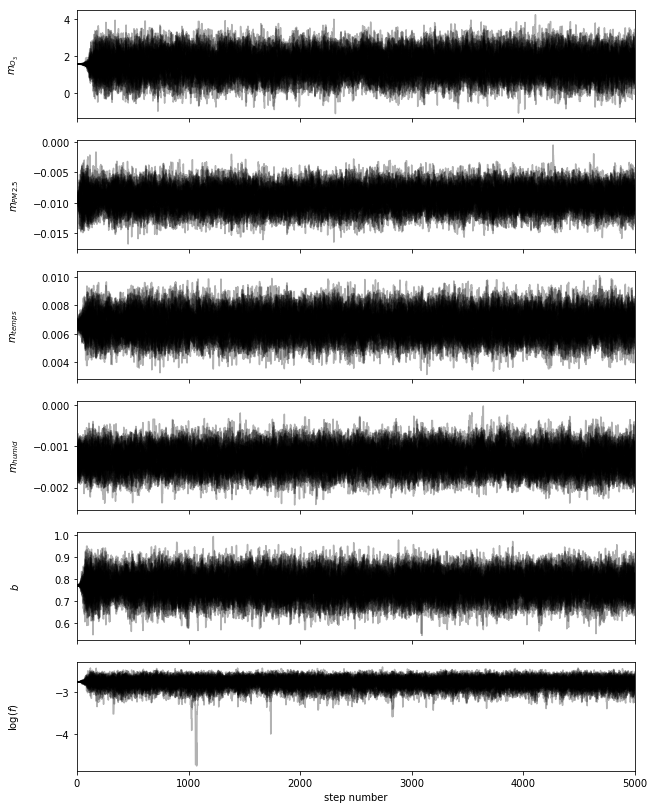

In [144]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
samples = sampler.get_chain()
labels = [r'$m_{O_3}$', r'$m_{PM2.5}$', r'$m_{temps}$', r'$m_{humid}$', r'$b$', r'$\log(f)$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [107]:
# -- Estimated autocorrelation time 
# -- # of steps needed for the chain to "forget" where it started

tau = sampler.get_autocorr_time()
print(tau)

[63.42831924 57.19381362 59.29005041 61.48782032 57.93373235 60.1900404 ]


In [108]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=200, thin=30, flat=True)
print(flat_samples.shape)

(8000, 6)


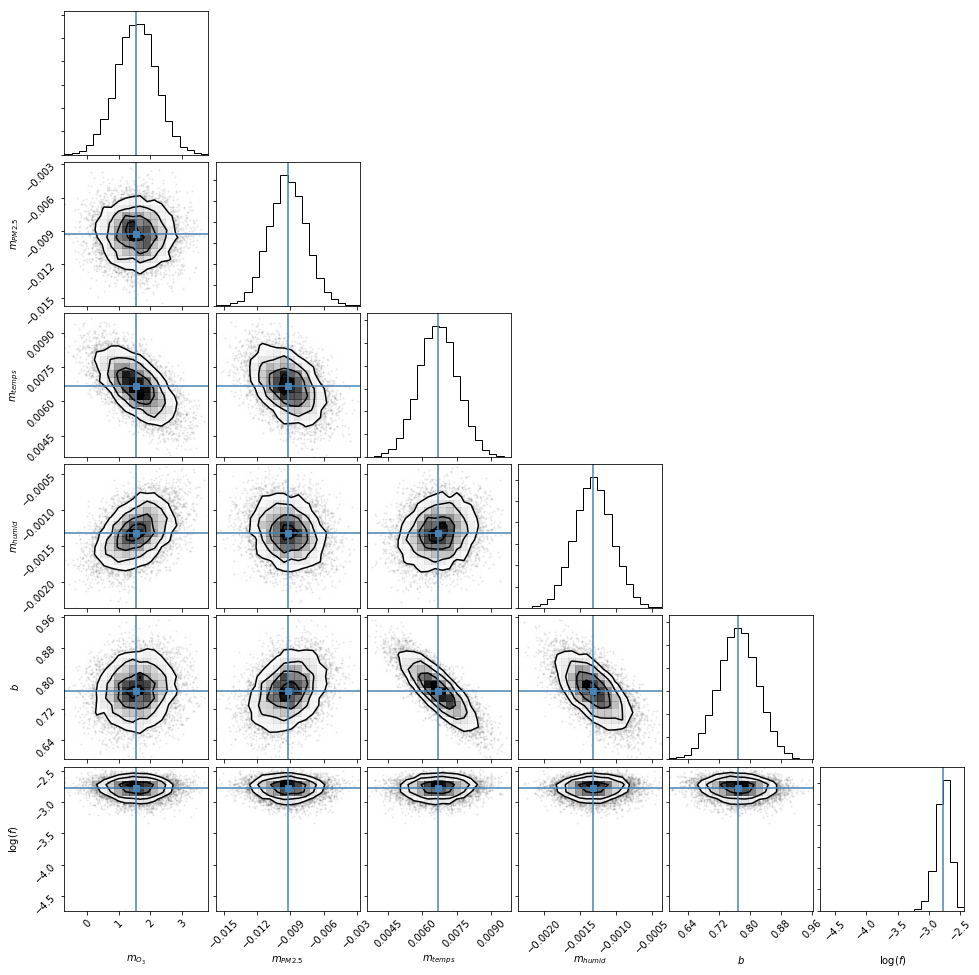

In [145]:
# -- Corner Plot

import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [146]:
# -- Using 16th, 50th, and 84th percentiles of samples in margenalized distributions as uncertainties

from IPython.display import display, Math

labels = ["m_{O_3}", "m_{PM2.5}", "m_{temps}", "m_{humid}", "b", "log(f)"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

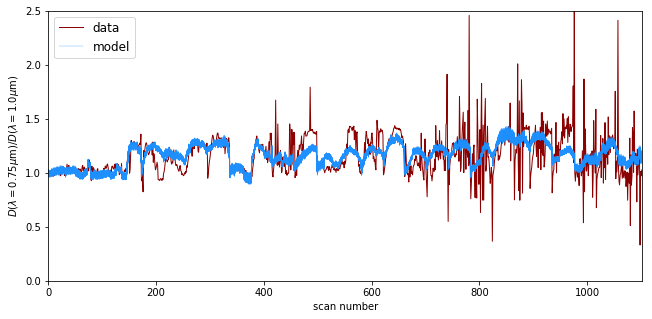

In [147]:
fig, ax = plt.subplots(figsize=[10,5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = plt.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = plt.plot(np.dot(templates, sample[:5]), color="dodgerblue", lw=0.3)
ax.set_ylim(0,2.5)
ax.set_xlim(0,pred.size)
ax.set_xlabel("scan number")
ax.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

## MCMC

but this time:

$brightness = m_{O_3} * O_3 + m_{PM2.5} * PM2.5 + m_{temp} * temp + m_{humid} * humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, epsilon, number_of_observations)

In [159]:
def lnprior(theta):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def lnlike(theta, o3, pm25, temps, humid, y):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def lnprob(theta, o3, pm25, temps, humid, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, o3, pm25, temps, humid, y)

In [160]:
from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -lnlike(*args)
initial = np.append(sol[0], berr)
result = minimize(nll, initial, args=(templates[:,0], templates[:,1], templates[:,2], 
                                    templates[:,3], brightness))
beta_o3_ml, beta_pm25_ml, beta_temps_ml, beta_humid_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("beta_o3 = {0:.5f}".format(beta_o3_ml))
print("beta_pm25 = {0:.5f}".format(beta_pm25_ml))
print("beta_temps = {0:.5f}".format(beta_temps_ml))
print("beta_humid = {0:.5f}".format(beta_humid_ml))
print("alpha = {0:.5f}".format(alpha_ml))
print("epsilon = {0:.5f}".format(epsilon_ml))

Maximum likelihood estimates:
beta_o3 = 1.57962
beta_pm25 = -0.00871
beta_temps = 0.00629
beta_humid = -0.00141
alpha = 0.79726
epsilon = 0.16594


In [161]:
nwalkers, ndim = 50, 6
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [162]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(templates[:,0], templates[:,1], 
                                      templates[:,2], templates[:,3], brightness))
pos, prob, state = sampler.run_mcmc(p0, 5000)

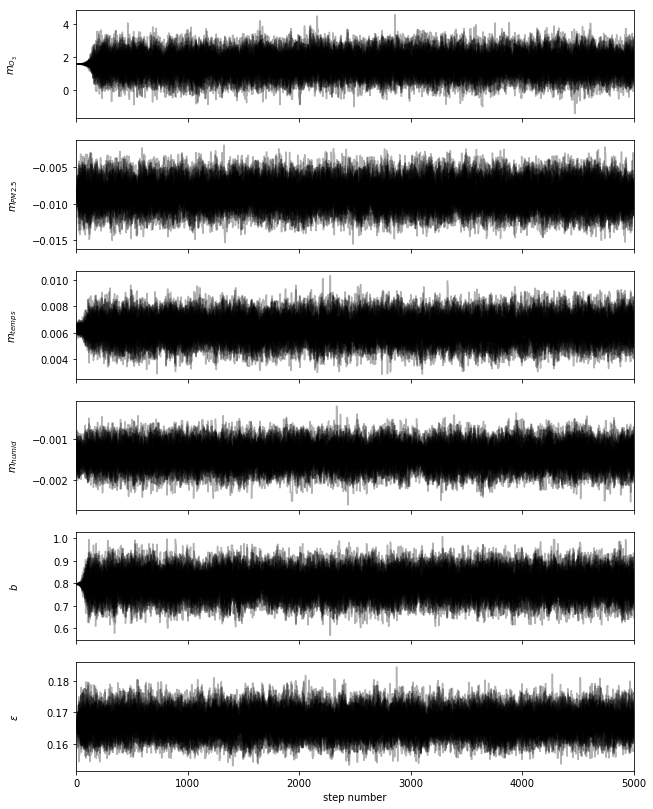

In [164]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
samples = sampler.get_chain()
labels = [r'$m_{O_3}$', r'$m_{PM2.5}$', r'$m_{temps}$', r'$m_{humid}$', r'$b$', r'$\epsilon$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [165]:
tau = sampler.get_autocorr_time()
print(tau)

[61.57534386 63.4816513  60.89994222 60.42576368 59.19845127 62.96867936]


In [166]:
flat_samples = sampler.get_chain(discard=200, thin=30, flat=True)
print(flat_samples.shape)

(8000, 6)


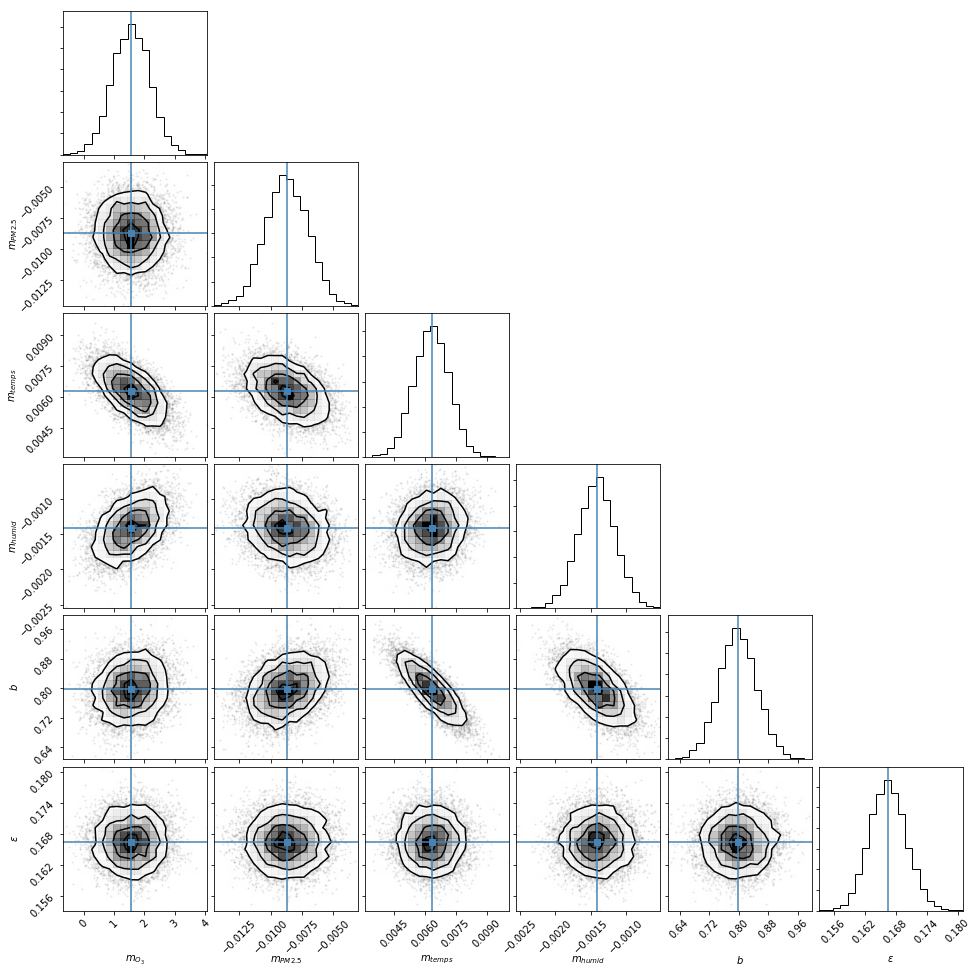

In [167]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [168]:
from IPython.display import display, Math

labels = ["m_{O_3}", "m_{PM2.5}", "m_{temps}", "m_{humid}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

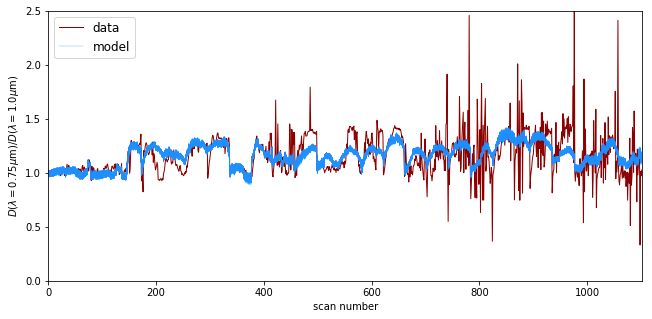

In [169]:
fig, ax = plt.subplots(figsize=[10,5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = plt.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = plt.plot(np.dot(templates, sample[:5]), color="dodgerblue", lw=0.3)
ax.set_ylim(0,2.5)
ax.set_xlim(0,pred.size)
ax.set_xlabel("scan number")
ax.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()